# Differences in sentiment of speech across age and gender

This notebook contains all of the analyses for Group 13's final project in Linguistics 1. 

### Project Proposal

1. **Issue/Behavior of interest** We are interested in exploring how the sentiment of conversations differ across gender and age demographics. Perhaps there is a gender difference in the overall sentiment of conversations, distributions of positive and negative words, or perhaps the gender makeup of the conversations (man-to-man vs. man-to-woman vs. woman-to-woman) result in significant differences in the words. These are the general questions we are interested in pursuing.

2. **Research Question** Are there any notable differences in the sentiment of words across different genders (male, female) or age groups?

3. **Proposed Methods** We plan to compare the sentiment of content words across different speaker populations (male, female, young, old). Doing sentiment analysis will be slightly complicated, but open source sentiment analysis software (NLTK, SentiWordNet) will simplify the task immensely. 

4. **Further Questions** Is there a dependence on the speaker’s content words (either frequency or sentiment) on the listener? Are there interaction effects between the age and sex of a speaker on the sentiment of their speech? 

## Data Preprocessing

The raw data contains 17683 entries. Each entry corresponds to a single word, and a number of features related to the setting in which the word was spoken:
* Cafe Name
* Time of Day
* Speaker Age and Gender
* Listener 1 and 2 Age and Gender
* Theme/Topic
* Formality (Informal, Neutral, Formal)

### Fixing Ages
Many of the recorded ages included ranges rather than single numbers (e.g. '18-25', '30s'). In these cases, we approximate these ages with the mean of the range.

### Phrases to words
Despite clear instruction, some students failed to understand that the 'Content Words (one word, not phrases)' column was to contain one word, not phrases. We limit our analysis to entries with only a single word in the Content Words column.

The CSV with the clean data can be found [here](all_clean_data.csv). It only contains columns with Speaker Age and Gender, Listener 1 Age and Gender, Theme/Topic (with an additional logical column indicating whether it is about 'family'), and the content word. 

## Loading the Data

Now that we have the data in a clean CSV file, we need to get it in a format that we can use in python for further analysis. We'll use [pandas](http://pandas.pydata.org/), a popular tool for handling data in python.

In [389]:
import pandas
all_data = pandas.read_csv('all_clean_data.csv')

Here's the top of our data table:

In [390]:
content_word_list = all_data['Content Word'].tolist()
all_data.head()

,Speaker Age,Speaker Gender,Listener 1 Age,Listener 1 Gender,Content Word,Theme/Topic,Is about Family
0,45,male,15,female,Allergic,Allergies,0
1,45,male,15,female,Reactions,Allergies,0
2,45,male,15,female,Lactose,Allergies,0
3,45,male,15,female,Free,Allergies,0
4,45,male,15,female,Milk,Allergies,0


## Sentiment Analysis

Our project makes use of 'sentiment analysis', a technique in natural language processessing that evaluates the sentiment of words, sentences, or other bodies of text [citation](http://www.cs.cornell.edu/home/llee/papers/sentiment.pdf). There are many approaches to sentiment analysis. Because we have content words rather than full sentences or paragraphs, we use a 'bag-of-words' model. A straightforward approach to sentiment analysis generally has 3 major steps. The first is to tokenize the text in question, which is nothing more than separating the text into individual words. After tokenizing, one performs feature extraction. A feature is essentially a characteristic of the data, and the values of specific features can vary depending on whether the review is positive or negative. Then, a classifier can be trained on a training set, using the values for the features and the actual classification before testing. We use an already trained classifier, SentiWordnet, to give us sentiment scores for each of the content words in the conversation data.


### SentiWordNet

SentiWordNet is a resource openly available designed to support sentiment classification [citation](http://nmis.isti.cnr.it/sebastiani/Publications/LREC10.pdf). The research team that produced the dataset through a semi-supervised machine learning approach. By initially manually classifying a small amount of the dataset with the correct sentiment score label, the model could then be trained and tested on slightly larger sets of data, using those results. Each word is eventually given a positive score, a negative score, and an objective score, each between zero and one. To get one overall score for each word, we computed word_score as the positive score - the negative score. In the cases where a word had multiple meanings, we simply averaged the score for each of its given definitions.

### Generating Sentiment Scores

After generating the score for each word, we'll look at differences between sentiment between populations (across age, gender).

Notes about these scores: as each word could have many meanings (each with different sentiments), we use the mean of the scores of all of the various meanings for a given word.

In [391]:
from os import listdir
from os.path import isfile, join, getsize
from collections import defaultdict
from collections import Counter
from os import getcwd
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import numpy as np
import time

has_sentiment = np.zeros(len(content_word_list));
content_word_positive_scores = -np.ones(len(content_word_list));
content_word_negative_scores = -np.ones(len(content_word_list));
content_word_objective_scores = -np.ones(len(content_word_list));

for i, word in enumerate(content_word_list):
    if not isinstance(word, float):
        synsets = swn.senti_synsets(word)
    #     print word
        if synsets:
            has_sentiment[i] = 1
            content_word_positive_scores[i] = np.mean([syns.pos_score() for syns in synsets])
            content_word_negative_scores[i] = np.mean([syns.neg_score() for syns in synsets])
            content_word_objective_scores[i] = np.mean([syns.obj_score() for syns in synsets])
        if i % 1000 == 0:
            print 'Processing word: ', i

all_data['Positive Score'] = content_word_positive_scores
all_data['Negative Score'] = content_word_negative_scores
all_data['Objective Score'] = content_word_objective_scores

Processing word:  0
Processing word:  1000
Processing word:  2000
Processing word:  3000
Processing word:  4000
Processing word:  5000
Processing word:  6000
Processing word:  7000
Processing word:  8000
Processing word:  9000
Processing word:  10000
Processing word:  11000
Processing word:  12000
Processing word:  13000
Processing word:  14000
Processing word:  15000


## Statistics of the Dataset

Total number of words:  15500
Number of words with sentiment data:  14112


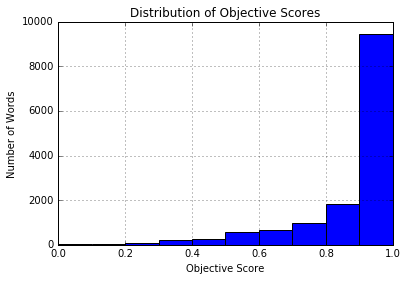

In [401]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
save_figures = True

print 'Total number of words: ', len(content_word_list)
print 'Number of words with sentiment data: ', int(sum(has_sentiment))
sentiment_data = all_data[has_sentiment == 1]
sentiment_data.loc[:, 'Sentiment Score'] = sentiment_data['Positive Score'] - sentiment_data['Negative Score']

male_speakers = sentiment_data[sentiment_data['Speaker Gender'] == 'male']
female_speakers = sentiment_data[sentiment_data['Speaker Gender'] == 'female']

sentiment_data['Objective Score'].hist()
plt.xlabel('Objective Score')
plt.ylabel('Number of Words')
plt.title('Distribution of Objective Scores') 
if save_figures:
    plt.savefig('Distribution of Objective Scores (Methods)', bbox_inches='tight', dpi=900)

The majority (around 2/3) of the words in our dataset are neutral. This is to be expected; most words in the English language do not carry an inherent positive or negative. However, for our analysis, we're going to restrict ourselves to looking at words that have nonzero either positive or negative scores.

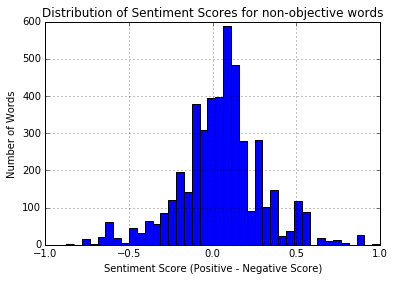

In [393]:
nonobjective_sentiment_data = sentiment_data[sentiment_data['Objective Score'] < .9]
nonobjective_sentiment_data.loc[:, 'Speaker Age'] = pandas.to_numeric(nonobjective_sentiment_data['Speaker Age'])
nonobjective_sentiment_data['Sentiment Score'].hist(bins=40)
plt.xlabel('Sentiment Score (Positive - Negative Score)')
plt.ylabel('Number of Words')
plt.title('Distribution of Sentiment Scores for non-objective words')
if save_figures:
    plt.savefig('Distribution of Sentiment Scores for non objective words (Methods)', bbox_inches='tight', dpi=900)

## Sentiment and Gender

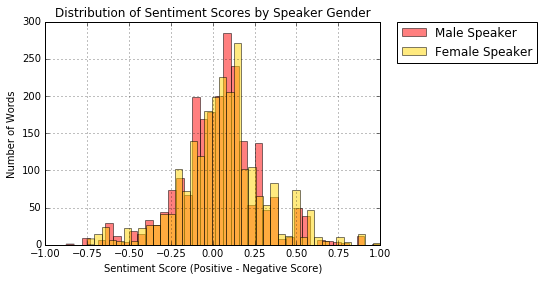

In [394]:
bin_size = 40
male_nonobjective = nonobjective_sentiment_data[nonobjective_sentiment_data['Speaker Gender'] == 'male']
male_nonobjective['Sentiment Score'].hist(bins=bin_size, alpha = .5, color = 'Red')

female_nonobjective = nonobjective_sentiment_data[nonobjective_sentiment_data['Speaker Gender'] == 'female']
female_nonobjective['Sentiment Score'].hist(bins=bin_size, alpha = .5, color = 'Gold')
plt.xticks(np.arange(-1, 1.01, .25))
plt.xlabel('Sentiment Score (Positive - Negative Score)')
plt.ylabel('Number of Words')
plt.legend(['Male Speaker', 'Female Speaker'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Distribution of Sentiment Scores by Speaker Gender')
if save_figures:
    plt.savefig('Distribution of Sentiment Scores by Speaker Gender (Results, Aim 1, Part 1)', bbox_inches='tight', dpi=900)

The distributions are mostly overlapping, perhaps slight more left skew for the male speakers. We further separate the data by listener gender.

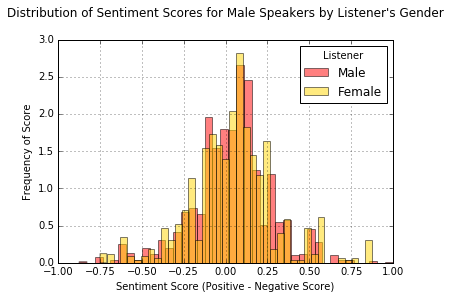

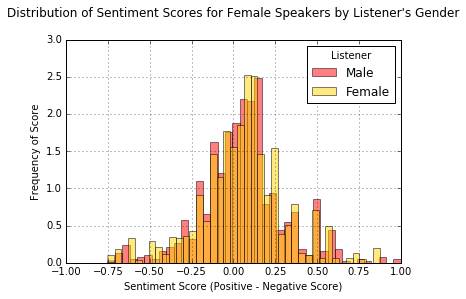

In [406]:
bin_size = 40
male_to_male = nonobjective_sentiment_data[(nonobjective_sentiment_data['Speaker Gender'] == 'male') & (nonobjective_sentiment_data['Listener 1 Gender'] == 'male')]
male_to_female = nonobjective_sentiment_data[(nonobjective_sentiment_data['Speaker Gender'] == 'male') & (nonobjective_sentiment_data['Listener 1 Gender'] == 'female')]


plt.figure()
male_to_male['Sentiment Score'].hist(bins=bin_size, alpha = .5, color = 'Red', normed=True)
male_to_female['Sentiment Score'].hist(bins=bin_size, alpha = .5, color = 'Gold', normed=True)


plt.xticks(np.arange(-1, 1.01, .25))
plt.xlabel('Sentiment Score (Positive - Negative Score)')
plt.ylabel('Frequency of Score')
plt.legend(['Male Listener', 'Female Listener'], title='Listener')
plt.title('Distribution of Sentiment Scores for Male Speakers by Listener\'s Gender', y=1.08)
plt.legend(['Male', 'Female'], title='Listener')
if save_figures:
    plt.savefig('Distribution of Sentiment Scores for Male Speakers by Listener\'s Gender (Results, Aim 1, Part 2)', bbox_inches='tight', dpi=700)

plt.figure()
female_to_female = nonobjective_sentiment_data[(nonobjective_sentiment_data['Speaker Gender'] == 'female') & (nonobjective_sentiment_data['Listener 1 Gender'] == 'female')]
female_to_male = nonobjective_sentiment_data[(nonobjective_sentiment_data['Speaker Gender'] == 'female') & (nonobjective_sentiment_data['Listener 1 Gender'] == 'male')]
female_to_male['Sentiment Score'].hist(bins=bin_size, alpha = .5, color = 'Red', normed=True)
female_to_female['Sentiment Score'].hist(bins=bin_size, alpha = .5, color = 'Gold', normed=True)

plt.xticks(np.arange(-1, 1.01, .25))
plt.xlabel('Sentiment Score (Positive - Negative Score)')
plt.ylabel('Frequency of Score')
plt.legend(['Male', 'Female'], title='Listener')
plt.title('Distribution of Sentiment Scores for Female Speakers by Listener\'s Gender', y=1.08)
if save_figures:
    plt.savefig('Distribution of Sentiment Scores for Female Speakers by Listener\'s Gender (Results, Aim 1, Part 2)', bbox_inches='tight', dpi=700)


## Sentiment and Age

In [396]:
teens = nonobjective_sentiment_data[(nonobjective_sentiment_data['Speaker Age'] < 18)]
young_adults = nonobjective_sentiment_data[(nonobjective_sentiment_data['Speaker Age'] > 18) &  (nonobjective_sentiment_data['Speaker Age'] < 30)]
adults = nonobjective_sentiment_data[(nonobjective_sentiment_data['Speaker Age'] > 30) & (nonobjective_sentiment_data['Speaker Age'] < 65)]
seniors = nonobjective_sentiment_data[(nonobjective_sentiment_data['Speaker Age'] > 65)]
groups = [teens, young_adults, adults, seniors]

teen_color = '#9F955F'
young_adult_color = '#649B5B'
adult_color = '#373677'
senior_color = '#814176'
age_group_labels = ['Teens', 'Young Adults', 'Adults', 'Seniors']

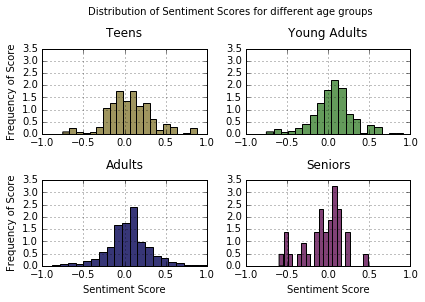

In [397]:
fig = plt.figure()
bin_size = 20

plt.subplot(2,2,1)
plt.title('Teens', y=1.08)
plt.ylabel('Frequency of Score')
teens['Sentiment Score'].hist(normed=True, bins = bin_size, color = teen_color)
plt.xticks(np.arange(-1, 1.01, .5))
plt.ylim([0, 3.5])

plt.subplot(2,2,2)
plt.title('Young Adults', y=1.08)
young_adults['Sentiment Score'].hist(normed=True, bins = bin_size, color = young_adult_color)
plt.xticks(np.arange(-1, 1.01, .5))
plt.ylim([0, 3.5])

plt.subplot(2,2,3)
plt.title('Adults', y=1.08)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency of Score')
adults['Sentiment Score'].hist(normed=True, bins = bin_size, color = adult_color)
plt.xticks(np.arange(-1, 1.01, .5))
plt.ylim([0, 3.5])


plt.subplot(2,2,4)
plt.title('Seniors', y=1.08)
plt.xlabel('Sentiment Score')
seniors['Sentiment Score'].hist(normed=True, bins = bin_size, color = senior_color)
plt.xticks(np.arange(-1, 1.01, .5));
plt.ylim([0, 3.5])


fig.suptitle('Distribution of Sentiment Scores for different age groups', y=1.03, x = .54)
plt.tight_layout()
if save_figures:
    plt.savefig('Distribution of Sentiment Scores for different age groups (Results, Aim 2, Part 1)', bbox_inches='tight', dpi=900)

For Teens, mean sentiment of word is 0.0606840518991 with std 0.273621479254
The percentage of words spoken with negative sentiment: 0.403041825095

For Young Adults, mean sentiment of word is 0.0530847925795 with std 0.250618304533
The percentage of words spoken with negative sentiment: 0.352215367358

For Adults, mean sentiment of word is 0.0378307799331 with std 0.248671014686
The percentage of words spoken with negative sentiment: 0.38738170347

For Seniors, mean sentiment of word is -0.0559452189789 with std 0.239128021864
The percentage of words spoken with negative sentiment: 0.5



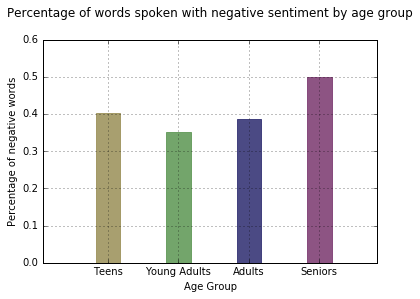

In [404]:
color_array = [teen_color, young_adult_color, adult_color, senior_color]

means = [teens['Sentiment Score'].mean(), young_adults['Sentiment Score'].mean(), adults['Sentiment Score'].mean(), seniors['Sentiment Score'].mean()]
stds = [teens['Sentiment Score'].std(), young_adults['Sentiment Score'].std(), adults['Sentiment Score'].std(), seniors['Sentiment Score'].std()]
negative_percentages = [sum(group['Sentiment Score'] < 0)/float(len(group)) for group in groups]



for group, mean, std, neg in zip(age_group_labels, means, stds, negative_percentages):
    print 'For {}, mean sentiment of word is {} with std {}'.format(group, mean, std)
    print 'The percentage of words spoken with negative sentiment: {}\n'.format(neg)


fig, ax = plt.subplots()

plt.title('Percentage of words spoken with negative sentiment by age group', y=1.08)
plt.xlabel('Age Group')
plt.ylabel('Percentage of negative words')
plt.ylim([0,.6])
ind = np.arange(len(negative_percentages))
width = 0.35
ax.set_xticks(ind + width/2.)
ax.set_xticklabels((age_group_labels))
rects = ax.bar(ind, negative_percentages, width, color='r', alpha = .9)
for color, group in zip(color_array, rects):
    group.set_color(color)
plt.xlim([-.75, 4])
plt.grid(True)
if save_figures:
    plt.savefig('Percentage of words spoken with negative sentiment by age group (Results, Aim 2, Part 2)', bbox_inches='tight', dpi=900)

The means aren't very different, but the percentage of words with negative sentiment follow a more interesting pattern.